In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import vpt_smape, vpt_nrmse, vpt_mse, smape_rolling
from scipy.spatial.distance import cdist
from dysts.systems import get_attractor_list
from dysts.flows import __dict__ as flow_models
from dysts.analysis import gp_dim
from dysts.metrics import estimate_kl_divergence
import os

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/analysis.py:28: UserWarning: Sklearn not installed. Will not be able to use ridge regression for gpdistance and corr_gpdim.
  warnings.warn(


In [2]:
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    #"amazon/chronos-t5-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    "amazon/chronos-bolt-base",
    #device_map="cuda",  # use "cpu" for CPU inference
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
granularity = 30
#context_lengths = 2**np.arange(6, 14)
context_lengths = 2**np.arange(6, 11)
forecast_length = 300
#simulation_length = 10000
simulation_length = 100000
rolling_window = context_lengths[-1]
num_ic = 20

# Directory to store trajectories
#trajectory_dir = "trajectories"
trajectory_dir = "long_trajectories"
os.makedirs(trajectory_dir, exist_ok=True)

equation_names = get_attractor_list()
equation_names.remove('FluidTrampoline')
equation_names.remove('HyperLu')
equation_names.remove('SprottMore')
equation_names.remove('StickSlipOscillator')
#equation_names = equation_names[:2]

In [4]:
def mse(y_true, y_pred):
    
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def mse_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mse = list()
    for i in range(1, n+1):
        mse_val = mse(ts1[:i], ts2[:i])
        all_mse.append(mse_val)

    return np.array(all_mse)

def mae(y_true, y_pred):
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def mae_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mae = list()
    for i in range(1, n+1):
        mae_val = mae(ts1[:i], ts2[:i])
        all_mae.append(mae_val)

    return np.array(all_mae)

In [5]:
average_vpt = dict()
median_vpt = dict()
average_smape = dict()
median_smape = dict()

average_vpt_2 = dict()
median_vpt_2 = dict()
average_smape_2 = dict()
median_smape_2 = dict()

average_cdim = dict()
median_cdim = dict()
average_kl = dict()
median_kl = dict()

average_mse = dict()
median_mse = dict()
average_mae = dict()
median_mae = dict()

In [6]:
for equation_name in equation_names:

    try:

        # Path to the trajectory file
        trajectory_path = os.path.join(trajectory_dir, f"{equation_name}.npy")

        # Check if the trajectory file already exists
        if os.path.exists(trajectory_path):
            print(f"Loading existing trajectory for {equation_name}...")
            traj = np.load(trajectory_path)
        else:
            # Generate the trajectory
            print(f"Generating trajectory for {equation_name}...")
            model_class = flow_models[equation_name]  # Get the model class dynamically
            model = model_class()  # Instantiate the model
            traj = model.make_trajectory(simulation_length, pts_per_period=granularity)

            # Save the trajectory
            np.save(trajectory_path, traj)
            print(f"Saved trajectory for {equation_name} at {trajectory_path}")

        # normalize the trajectory
        traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

        for context_length in context_lengths:

            all_vpt = list() # collecting all vpt for the parroting model
            all_smape_rolling = list() # collecting all smape values across time
            all_vpt_2 = list() # collecting all vpt for the parroting model
            all_smape_rolling_2 = list() # collecting all smape values across time
            all_cdim = list() # collecting all correlation dimensions
            all_kl_dist = list() # collecting all kl divergence values
            all_mse_rolling = list()
            all_mae_rolling = list()

            for i in range(0, len(traj)-context_length-forecast_length, rolling_window):
                if i < rolling_window*num_ic:
                    #print(i//rolling_window)
                    traj_context = traj[i:i+context_length,:]
                    traj_true = traj[i+context_length:i+context_length+forecast_length,:]
                    traj_pred_full = np.zeros_like(traj_true)

                    for dim in range(traj_true.shape[1]):

                        forecast = pipeline.predict(
                            context=torch.tensor(traj_context[:,dim]),
                            prediction_length=forecast_length,
                            #num_samples=1,
                            limit_prediction_length=False,
                            )
                        #traj_pred = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
                        traj_pred = forecast[0,4,:].numpy()
                        traj_pred_full[:,dim] = traj_pred

                        vpt = vpt_smape(traj_pred, traj_true[:,dim]) / granularity
                        smape_val = np.array(smape_rolling(traj_true[:, dim], traj_pred))

                        all_vpt.append(vpt)
                        all_smape_rolling.append(smape_val)

                        mse_val = mse_rolling(traj_true[:, dim], traj_pred)
                        all_mse_rolling.append(mse_val)
                        
                        mae_val = mae_rolling(traj_true[:, dim], traj_pred)
                        all_mae_rolling.append(mae_val)

                    vpt = vpt_smape(traj_pred_full.squeeze(), traj_true.squeeze()) / granularity
                    smape_val = np.array(smape_rolling(traj_true, traj_pred_full))
                    all_vpt_2.append(vpt)
                    all_smape_rolling_2.append(smape_val)
                    
                    kl_dist = estimate_kl_divergence(traj_true, traj_pred_full)
                    if np.isinf(kl_dist):
                        kl_dist = np.nan
                    all_kl_dist.append(kl_dist)

                    cdim_pred = gp_dim(traj_pred_full)
                    cdim_true = gp_dim(traj_true)
                    all_cdim.append(np.array([cdim_pred, cdim_true]))

            average_vpt[(equation_name,context_length)] = np.mean(all_vpt)
            median_vpt[(equation_name,context_length)] = np.median(all_vpt)
            average_smape[(equation_name,context_length)] = np.mean(all_smape_rolling, axis=0)
            median_smape[(equation_name,context_length)] = np.median(all_smape_rolling, axis=0)

            average_vpt_2[(equation_name,context_length)] = np.mean(all_vpt_2)
            median_vpt_2[(equation_name,context_length)] = np.median(all_vpt_2)
            average_smape_2[(equation_name,context_length)] = np.mean(all_smape_rolling_2, axis=0)
            median_smape_2[(equation_name,context_length)] = np.median(all_smape_rolling_2, axis=0)

            average_cdim[(equation_name,context_length)] = np.mean(all_cdim, axis=0)
            median_cdim[(equation_name,context_length)] = np.median(all_cdim, axis=0)
            average_kl[(equation_name,context_length)] = np.nanmean(all_kl_dist)
            median_kl[(equation_name,context_length)] = np.nanmedian(all_kl_dist)

            average_mse[(equation_name,context_length)] = np.mean(all_mse_rolling, axis=0)
            median_mse[(equation_name,context_length)] = np.median(all_mse_rolling, axis=0)
            average_mae[(equation_name,context_length)] = np.mean(all_mae_rolling, axis=0)
            median_mae[(equation_name,context_length)] = np.median(all_mae_rolling, axis=0)
            
            
    except Exception as e:
        print(e)
        print(f"Skipping {equation_name}", flush=True)
        continue
                

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/chronos/chronos_bolt.py:527: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Loading existing trajectory for Aizawa...
Loading existing trajectory for AnishchenkoAstakhov...
Loading existing trajectory for Arneodo...
Loading existing trajectory for ArnoldBeltramiChildress...
Loading existing trajectory for ArnoldWeb...


/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: divide by zero encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: overflow encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


Loading existing trajectory for AtmosphericRegime...
Loading existing trajectory for BeerRNN...
Loading existing trajectory for BelousovZhabotinsky...
Loading existing trajectory for BickleyJet...
Loading existing trajectory for Blasius...
Loading existing trajectory for BlinkingRotlet...
Loading existing trajectory for BlinkingVortex...
Loading existing trajectory for Bouali...
Loading existing trajectory for Bouali2...
Loading existing trajectory for BurkeShaw...
Loading existing trajectory for CaTwoPlus...
Loading existing trajectory for CaTwoPlusQuasiperiodic...
Loading existing trajectory for CellCycle...
Loading existing trajectory for CellularNeuralNetwork...
Loading existing trajectory for Chen...
Loading existing trajectory for ChenLee...
Loading existing trajectory for Chua...
Loading existing trajectory for CircadianRhythm...
Loading existing trajectory for CoevolvingPredatorPrey...
Loading existing trajectory for Colpitts...
Loading existing trajectory for Coullet...
Loadin

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/metrics.py:543: RuntimeWarning: divide by zero encountered in divide
  log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/metrics.py:543: RuntimeWarning: overflow encountered in divide
  log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))


zero-size array to reduction operation minimum which has no identity
Skipping PanXuZhou
Loading existing trajectory for PehlivanWei...
Loading existing trajectory for PiecewiseCircuit...
Loading existing trajectory for Qi...
Loading existing trajectory for QiChen...
Loading existing trajectory for RabinovichFabrikant...
Loading existing trajectory for RayleighBenard...
Loading existing trajectory for RikitakeDynamo...
Loading existing trajectory for Rossler...
Loading existing trajectory for Rucklidge...
Loading existing trajectory for Sakarya...
Loading existing trajectory for SaltonSea...
Loading existing trajectory for SanUmSrisuchinwong...
Loading existing trajectory for ScrollDelay...
Loading existing trajectory for ShimizuMorioka...
Loading existing trajectory for SprottA...
Loading existing trajectory for SprottB...
Loading existing trajectory for SprottC...
Loading existing trajectory for SprottD...
Loading existing trajectory for SprottDelay...
Loading existing trajectory for 

In [7]:
np.save(f'./ChronosBolt_statistics_normalized/average_vpt.npy', average_vpt)
np.save(f'./ChronosBolt_statistics_normalized/median_vpt.npy', median_vpt) 
np.save(f'./ChronosBolt_statistics_normalized/average_smape.npy', average_smape)
np.save(f'./ChronosBolt_statistics_normalized/median_smape.npy', median_smape)
np.save(f'./ChronosBolt_statistics_normalized/average_vpt_2.npy', average_vpt_2)
np.save(f'./ChronosBolt_statistics_normalized/median_vpt_2.npy', median_vpt_2) 
np.save(f'./ChronosBolt_statistics_normalized/average_smape_2.npy', average_smape_2)
np.save(f'./ChronosBolt_statistics_normalized/median_smape_2.npy', median_smape_2)
np.save(f'./ChronosBolt_statistics_normalized/average_cdim.npy', average_cdim)
np.save(f'./ChronosBolt_statistics_normalized/median_cdim.npy', median_cdim)
np.save(f'./ChronosBolt_statistics_normalized/average_kl.npy', average_kl)
np.save(f'./ChronosBolt_statistics_normalized/median_kl.npy', median_kl)
np.save(f'./ChronosBolt_statistics_normalized/average_mse.npy', average_mse)
np.save(f'./ChronosBolt_statistics_normalized/median_mse.npy', median_mse)
np.save(f'./ChronosBolt_statistics_normalized/average_mae.npy', average_mae)
np.save(f'./ChronosBolt_statistics_normalized/median_mae.npy', median_mae)

In [8]:
## set all fonts to Helvetica
plt.rcParams["font.family"] = "Helvetica"

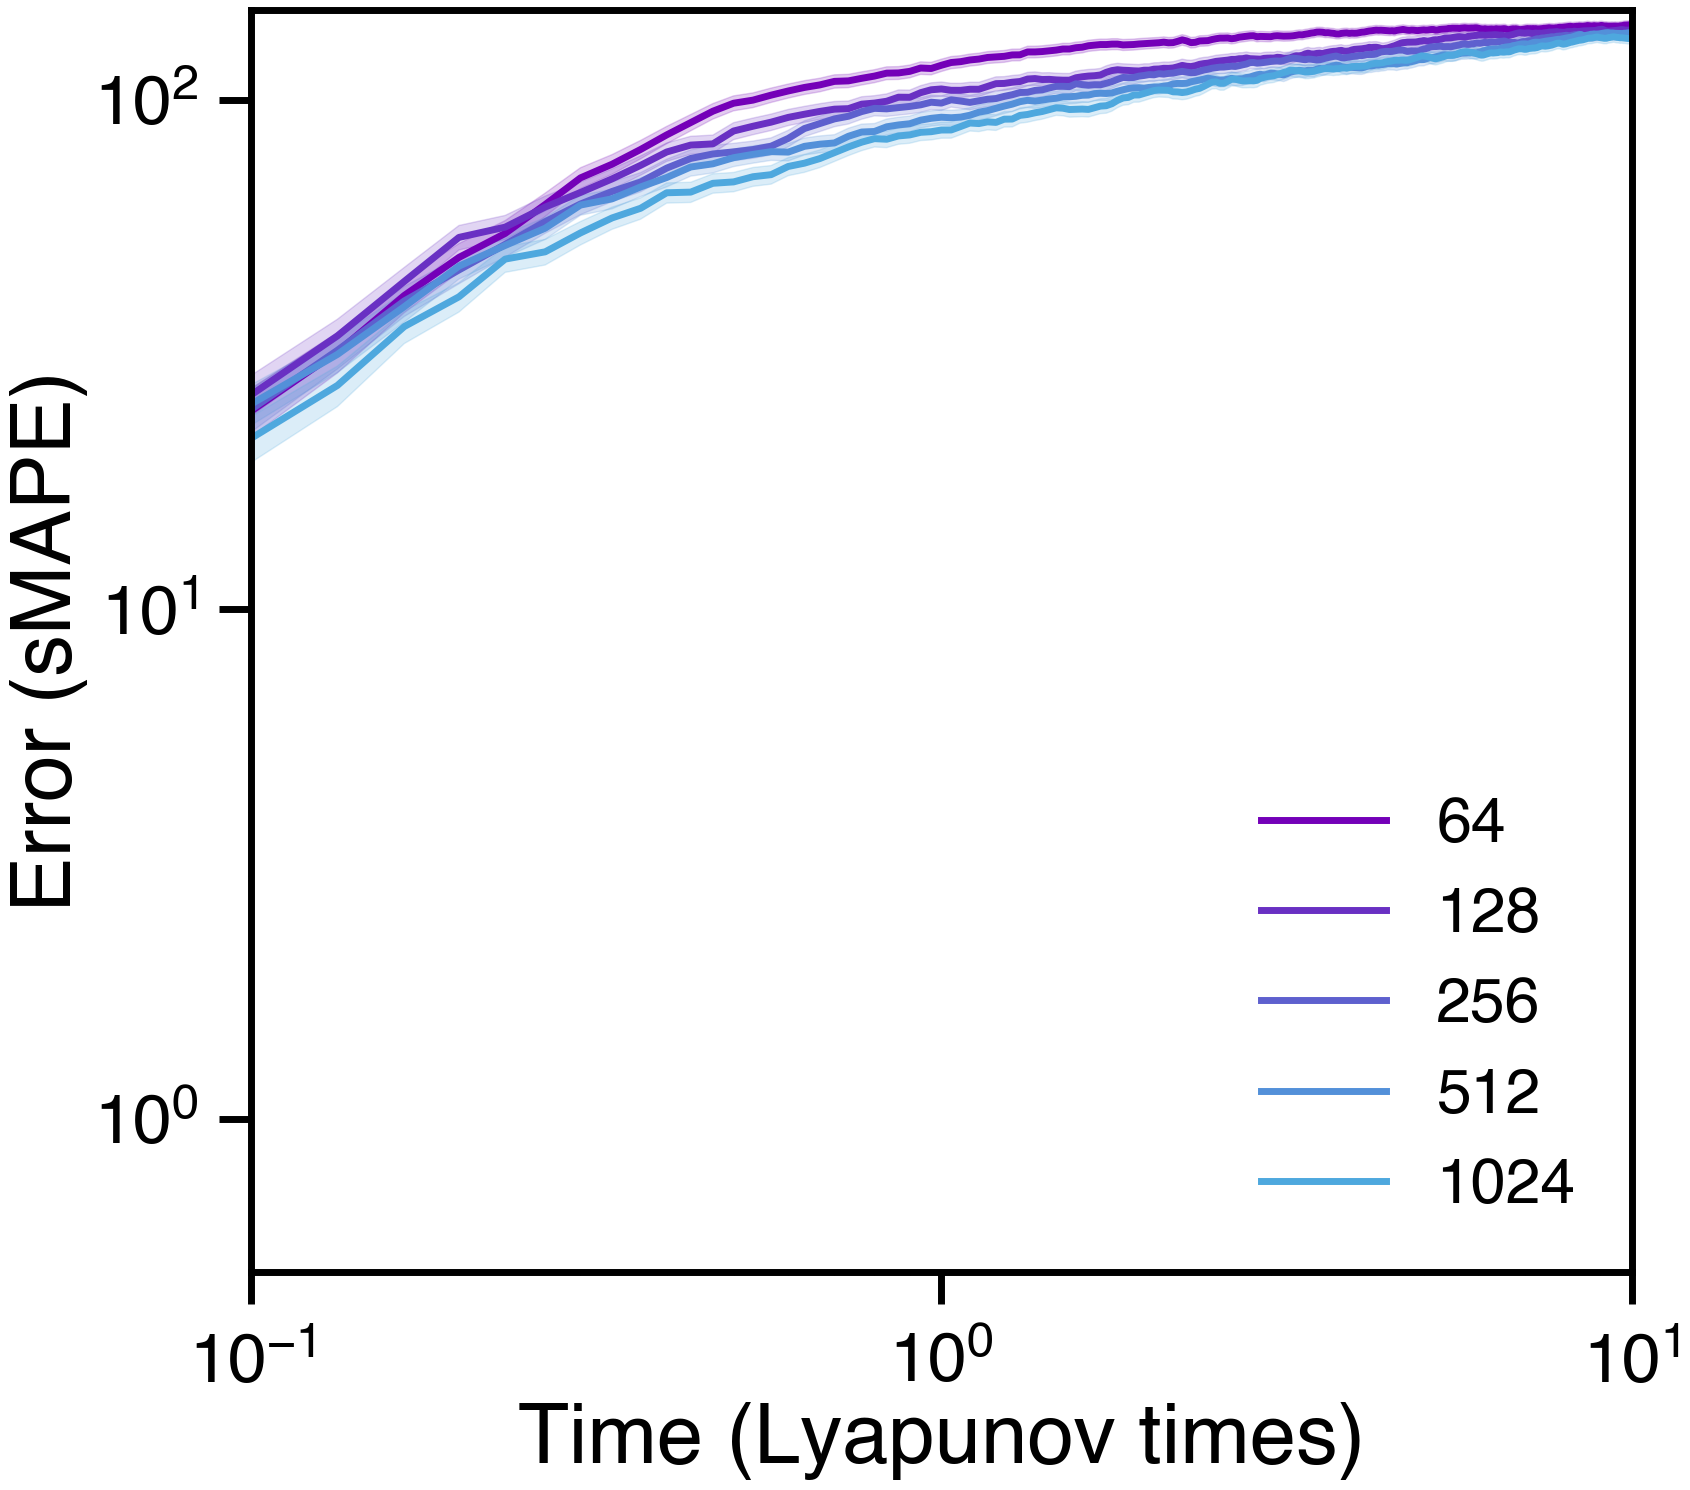

In [9]:
#import degas as dg
colors = ['#f94144', '#f3722c', '#f8961e', '#f9844a', '#f9c74f', '#90be6d', '#43aa8b', '#4d908e', '#577590', '#277da1']
colors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

time = np.arange(1/granularity, (forecast_length+1)/granularity, 1/granularity)

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Time (Lyapunov times)', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error (sMAPE)', fontname="Helvetica", fontsize = 60)
  
for i, context_length in enumerate(context_lengths):
  smape_trjs = [median_smape[(equation_name, context_length)] for equation_name, ctx in median_smape.keys() if ctx == context_length]
  smape_trj = np.median(smape_trjs, axis=0)
  smape_std = np.std(smape_trjs, axis=0)/np.sqrt(len(equation_names))
  plt.plot(time, smape_trj, lw=5, ls='-', alpha=1, color=colors[i], label=context_length)
  ax.fill_between(time, smape_trj - smape_std, smape_trj + smape_std, alpha=0.2, color=colors[i])
  #dg.plot_err(smape_trj, smape_std/1.0, x=time, color=colors[i], label=context_length, zorder=10*i)

plt.xscale('log')
plt.yscale('log')

plt.xlim([.1, 10])
plt.ylim([.5, 150])

plt.legend(loc='lower right', frameon=False, prop={'size':45}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'smape_rolling_chronos.pdf', bbox_inches='tight')